from torch.onnx._internal.fx._pass import Analysis
# StaVia TI for Spatio-temporal Analysis of single cell data
This tutorial focuses on how to use StaVia on single cell atlases that have spatial and temporal data. We use a Stereo-seq Zebrafish gastrulation dataset ZESTA (C. Liu et al. 2022) from 5hpf to 24hpf of 150,000 spots approaching single cell size. The preprocessed anndata object with all slices and time points merged on shared genes is available [here](https://drive.google.com/drive/folders/1xAxCnRfblwWqAujJSs_sqNhTx40GqN6Y?usp=sharing).

We show how to incorporate both spatial coordinates of cells on different tissue slices as well as temporal labels from known experimental/developmental time points

In [1]:
import scanpy as sc, numpy as np, pandas as pd, pyVIA.core as via

# download and read the data. 
foldername = '/home/user/Spatial/datasets/Zesta/'
fname_outer = 'Data/steroseq_alltimes_outerjoin_26628genes.h5ad'  # outer join of genes from each time point
fname = 'Data/stavia_spatialPCA100_spatialk15_weightp3.h5ad' #contains the PCs on the spatially smoothed genes. adata.X is the original non-smoothed gene expression, but the PCA is based on the spatially-smoothed gene matrix (which we dont save as its a big dense matrix)
print('fname:', fname)
adata = sc.read(foldername + fname)
#ad_outer = sc.read(foldername + fname_outer)
print(adata)

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-pac

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/phate/__init__.py
fname: Data/stavia_spatialPCA100_spatialk15_weightp3.h5ad
AnnData object with n_obs × n_vars = 152977 × 13615
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'time_str', 'time_num', 'coarse_celltype', 'fine_celltype', 'coarse_fine_celltype', 'via_clusters', 'coarse_celltype_stavia', 'fine_celltype_stavia', 'coarse_fine_celltype_stavia'
    uns: 'pca'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_adjusted', 'spatial_pca'
    varm: 'PCs'
    layers: 'counts'


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
true_labels_coarse = [i for i in adata.obs['coarse_celltype_stavia']]
true_labels_fine = [ i for i in adata.obs['fine_celltype_stavia']]
true_labels_hybrid = [i for i in adata.obs['coarse_fine_celltype_stavia']]

### Let's have a quick look at the data. We plot the cells/spots based on their tissue coordinates and color them by time point.

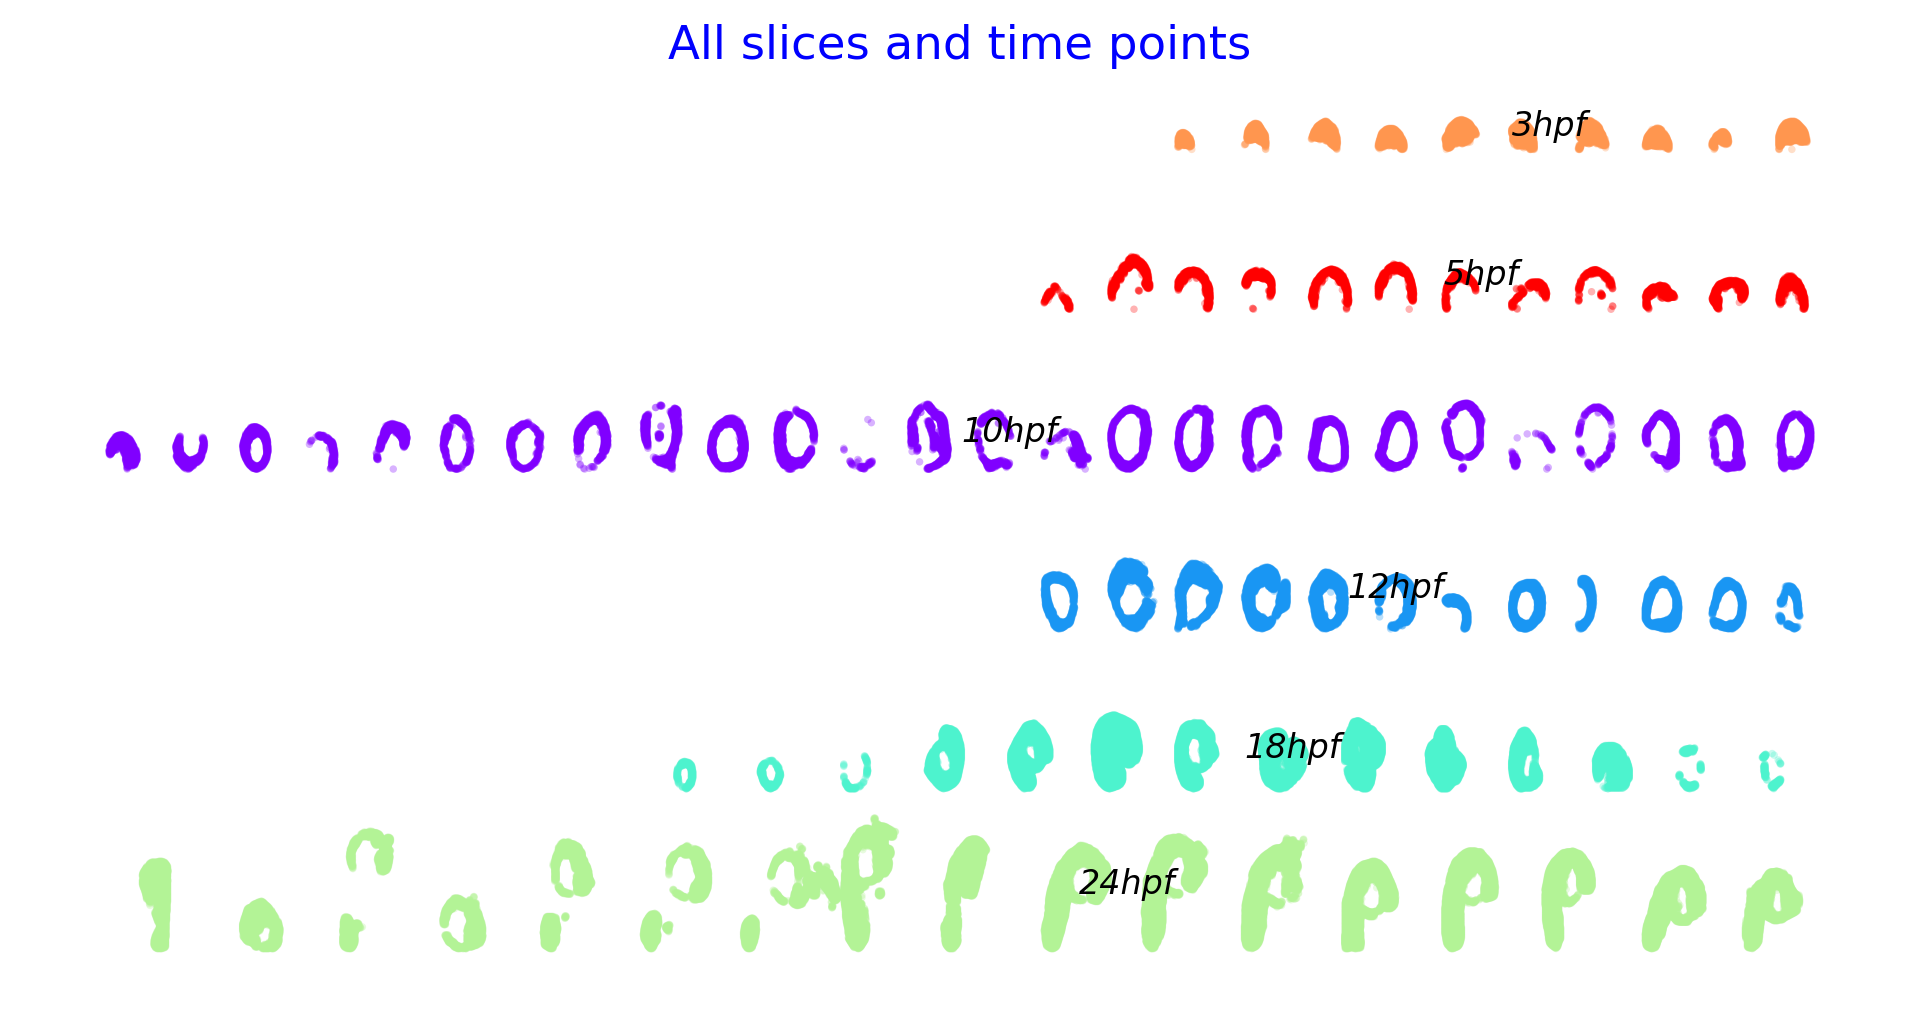

In [4]:
f,ax = via.plot_scatter(embedding=adata.obsm['X_spatial_adjusted'], labels=adata.obs['time_point'],                     title='All slices and time points', text_labels=True, show_legend=False)
f.set_size_inches(10, 5)

### Let's run StaVia and see what the trajectories look like.

- We demonstrate how to run StaVia under two slightly different settings here. 1) no precomupted cluster labels or user-defined terminal states and 2) Provide existing cluster labels and pass on prior knowledge of terminal cell fates
- We recommend saving down the PCs computed on the spatially-adjusted genes to avoid having to recompute this each time (it takes a few mins on larger data)
 

In [6]:
knn = 20  # (try 50 for no timeseries)
root = ["deep blastomere"]  
time_series = True
do_spatial = True
n_pcs = 30
spatial_knn = 10
use_prelabels = False  # True
knn_sequential = 5  # 10, 15 also good
t_diff_step = 2  # can also try 3 for embedding #2for viagraph
resolution_parameter = 1  # 1.5
cluster_graph_pruning= 2#0.15 #trying 2 for no time_series
edgepruning_clustering_resolution = 0.3#0.2  # 2
random_seed = 2  # 2
slices = [str(i) for i in adata.obs['slice']]
time_numeric = [int(float(i[:-3])) for i in adata.obs['time_point']]
spatial_aux = [str(x) + '_' + str(y) for (x, y) in zip(time_numeric, slices)]  # unique slice_ID for each slice in the dataset as otherwise each time point has some overlapping Slice IDs

print(f'time_series ({time_series}) and spatial_info ({do_spatial})')
pre_labels = [i for i in adata.obs['via_clusters']]
if use_prelabels:
    true_label = pre_labels #set annotations to the cluster labels
    #a list of cell types/clusters that are found in true_label and are viable terminal cell fates
    user_defined_terminal_group=[26,46,10, 13, 17, 21, 24, 28, 30, 34, 36, 37, 39, 41, 43, 53, 61, 64, 65, 71,20,57,66,29,22] 
    labels = pre_labels #preset the cluster-graph groupings
else: 
    labels = None
    user_defined_terminal_group = []
    true_label=true_labels_fine
if do_spatial:
    #compute the spatially adjusted principle components. This takes a few minutes, so its suggested to save these PCs into your anndata object for subsequent runs. 
    do_spatial_gene_smoothing = False #use the precomputed PCs from smoothed-genes saved in the anndata object. Set to True if you wish to recompute these 
    if do_spatial_gene_smoothing:
        #start spatially adjusting genes and PCs
        spatial_weight = 0.3  # contribution of spatial-nn to gene-expression vs. cell's own gene-expression
        print('run spatial_input_slices')
        X_spatial_exp0 = via.spatial_input(X_genes=adata.X.todense(),
                                           spatial_coords=np.asarray(adata.obsm['X_spatial']),
                                           knn_spatial=spatial_knn, spatial_weight=spatial_weight,
                                           spatial_slice_labels=spatial_aux)
    
        adata.obsm['X_gene_spatial_adjusted'] = X_spatial_exp0
        print('Start PCA on spatial_X')
        adata.obsm["spatial_pca"] = sc.tl.pca(adata.obsm['X_gene_spatial_adjusted'], n_comps=n_pcs)
        print('End PCA on spatial_X')
        del adata.obsm['X_gene_spatial_adjusted']  # too large (dense) to save down
        #end spatially adjusting genes and PCs
    
    input = adata.obsm['spatial_pca'][:, 0:n_pcs]
    coords = np.asarray(adata.obsm['X_spatial_adjusted'])
    print(f'spatial knn for graph construction {spatial_knn}')
    
else: 
    spatial_knn=None
    input = adata.obsm['X_pca'][:, 0:n_pcs]

v0 = via.VIA(data=input, true_label=true_label, 
                 edgepruning_clustering_resolution=edgepruning_clustering_resolution, labels=labels,
                 edgepruning_clustering_resolution_local=1, knn=knn, knn_sequential=knn_sequential,
                 knn_sequential_reverse=knn_sequential,
                 cluster_graph_pruning=cluster_graph_pruning,
                 neighboring_terminal_states_threshold=4,
                 too_big_factor=0.3, resolution_parameter=resolution_parameter,
                 root_user=root, dataset='group', random_seed=random_seed,
                 is_coarse=True, preserve_disconnected=True, pseudotime_threshold_TS=40, x_lazy=0.99,
                 t_diff_step=t_diff_step,
                 alpha_teleport=0.99, edgebundle_pruning_twice=False,
                 time_series_labels=time_numeric, time_series=time_series,
                spatial_aux=spatial_aux,
                 do_spatial_knn=do_spatial, do_spatial_layout=False, spatial_coords=coords, spatial_knn=spatial_knn)

v0.run_VIA()


time_series (True) and spatial_info (True)
spatial knn for graph construction 10
2024-05-08 08:48:00.117937	Running VIA over input data of 152977 (samples) x 30 (features)
2024-05-08 08:48:00.117961	Knngraph has 20 neighbors
2024-05-08 08:48:34.779144	Using time series information to guide knn graph construction 
2024-05-08 08:48:34.788837	Time series ordered set [3, 5, 10, 12, 18, 24]
2024-05-08 08:49:31.920568	Shape neighbors (152977, 20) and sequential neighbors (152977, 10)
2024-05-08 08:49:31.957006	Shape augmented neighbors (152977, 30)
2024-05-08 08:49:31.978508	Actual average allowable time difference between nodes is 8.4
2024-05-08 08:49:39.253519	Using spatial information to guide knn graph construction + combining with time-series data
2024-05-08 08:49:39.265923	These slices are present: ['10_1', '10_10', '10_11', '10_12', '10_13', '10_14', '10_15', '10_16', '10_17', '10_18', '10_19', '10_2', '10_20', '10_21', '10_22', '10_23', '10_24', '10_25', '10_26', '10_3', '10_4', '10_

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2024-05-08 08:51:09.018100	Identifying terminal clusters corresponding to unique lineages...
2024-05-08 08:51:09.018142	Closeness:[1, 2, 3, 4, 9, 14, 15, 16, 17, 19, 20, 23, 28, 29, 31, 32, 33, 37, 38, 39, 42, 44, 50, 52, 55]
2024-05-08 08:51:09.018161	Betweenness:[1, 2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 24, 25, 26, 28, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 44, 50, 53]
2024-05-08 08:51:09.018178	Out Degree:[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54]
2024-05-08 08:51:09.018518	We removed cluster 7 from the shortlist of terminal states
2024-05-08 08:51:09.018696	Cluster 8 had 4 or more neighboring terminal states [10, 12, 13, 14, 15, 18, 19, 20, 22, 24, 25, 26, 29, 30, 32, 36, 37, 38, 39, 40, 41, 42, 52] and so we removed cluster 30
2024-05-08 08:51:09.018733	We 

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-05-08 08:51:15.935942	Cluster or terminal cell fate 36 is reached 109.0 times
2024-05-08 08:51:16.006159	There are (1) terminal clusters corresponding to unique lineages {36: 'dPronephros'}
2024-05-08 08:51:16.006204	Begin projection of pseudotime and lineage likelihood


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/core.py:2479: RuntimeWarning: invalid value encountered in divide
  bp_array = bp_array / bp_array.sum(axis=1)[:, None]  # row normalization at the cluster level


2024-05-08 08:51:22.814234	Start reading data
2024-05-08 08:51:22.814311	Correlation of Via pseudotime with developmental stage 93.82 %
2024-05-08 08:51:22.844963	Cluster graph layout based on forward biasing
2024-05-08 08:51:22.857040	Starting make edgebundle viagraph...
2024-05-08 08:51:22.857065	Make via clustergraph edgebundle
2024-05-08 08:51:27.095135	Hammer dims: Nodes shape: (56, 2) Edges shape: (1628, 3)
2024-05-08 08:51:27.097243	Graph has 1 connected components before pruning
2024-05-08 08:51:27.101095	Graph has 18 connected components after pruning
2024-05-08 08:51:27.120289	Graph has 1 connected components after reconnecting
2024-05-08 08:51:27.121315	92.2% links trimmed from local pruning relative to start
2024-05-08 08:51:27.121349	93.9% links trimmed from global pruning relative to start
initial links 1437 and final_links_n 112
2024-05-08 08:51:27.197618	Time elapsed 177.3 seconds


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],


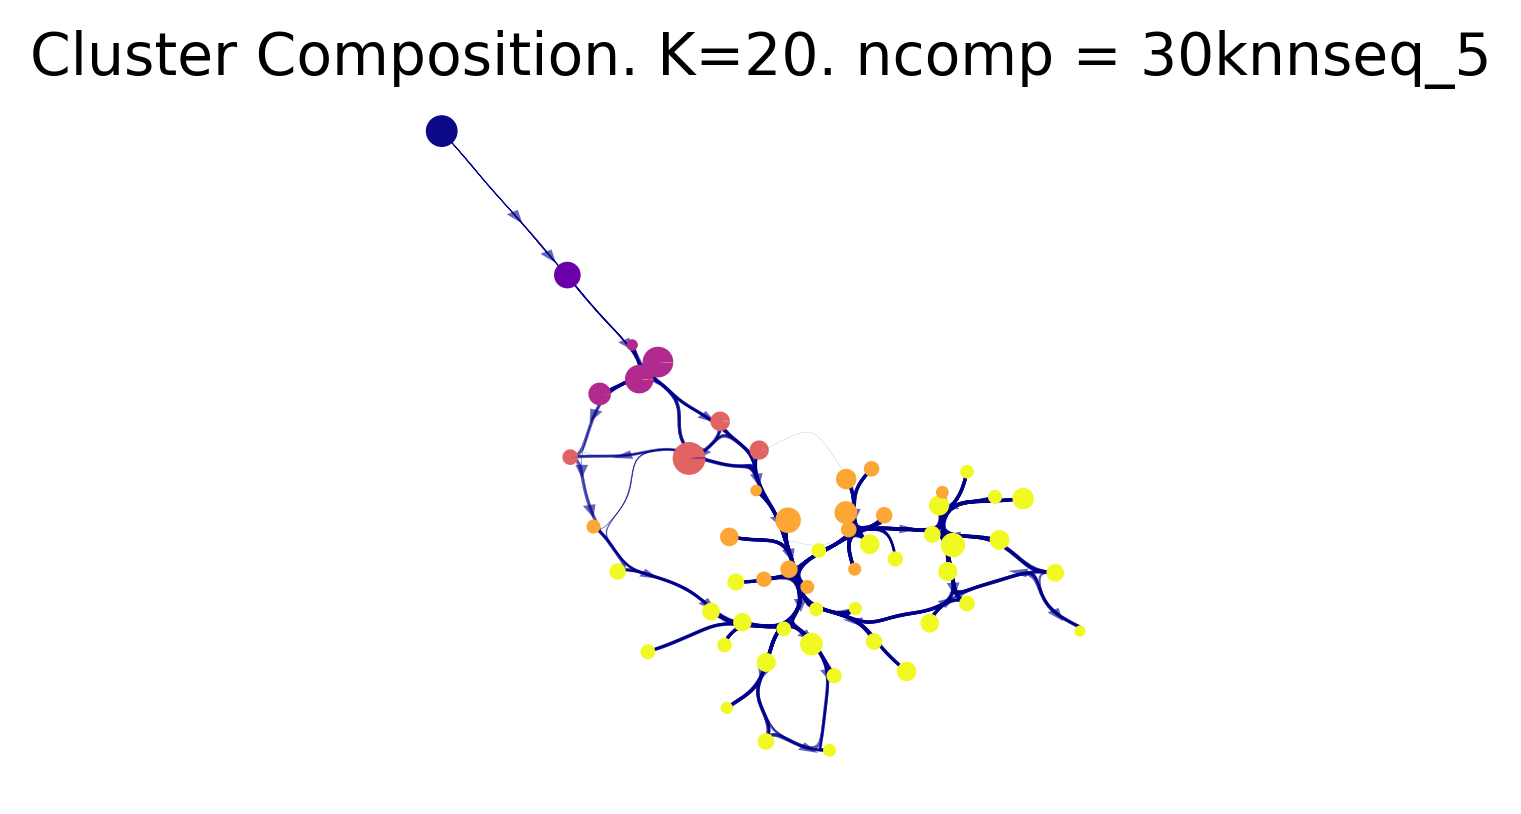

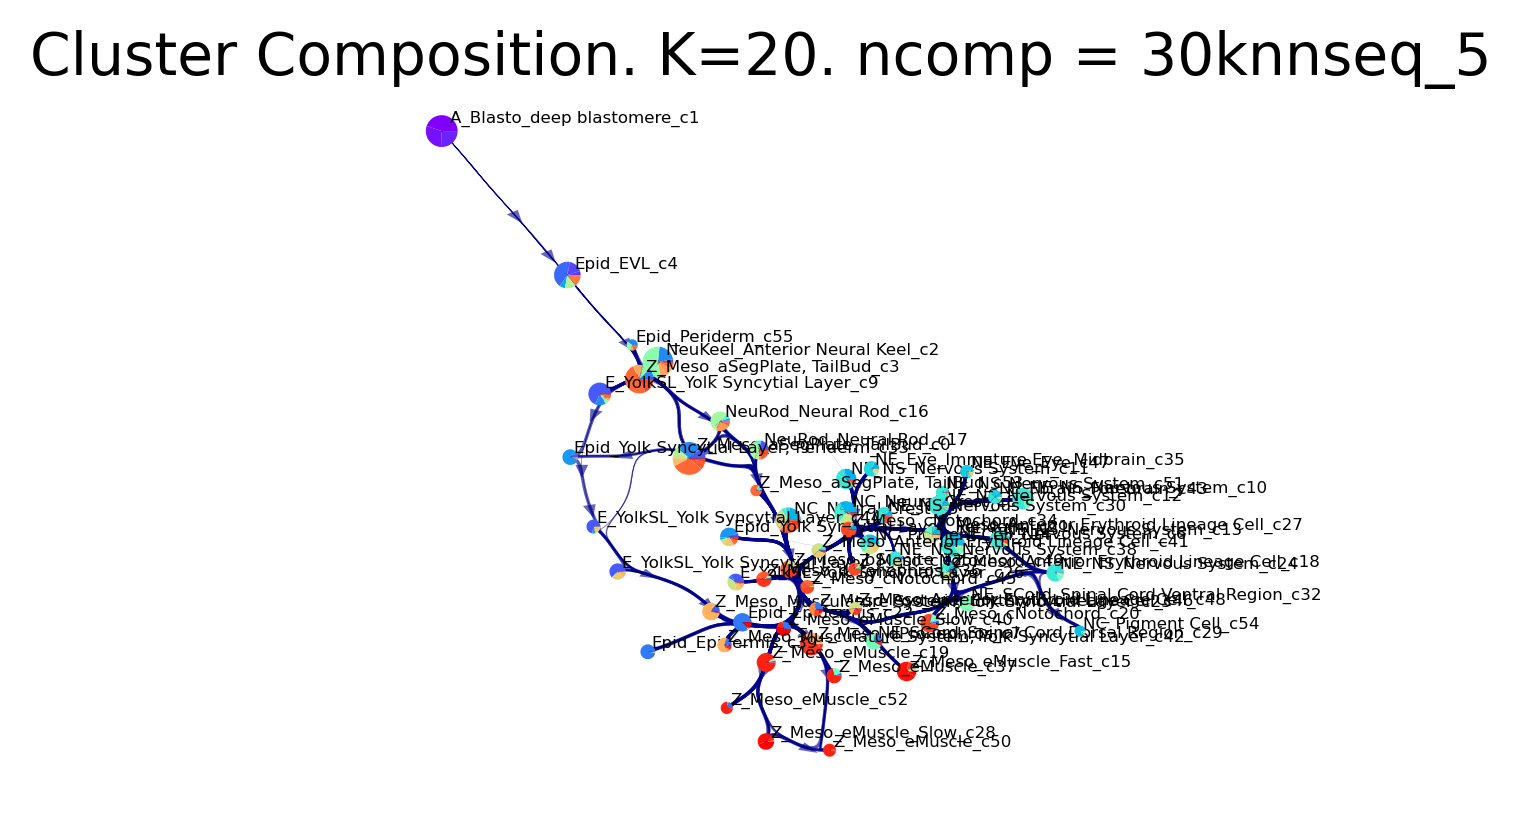

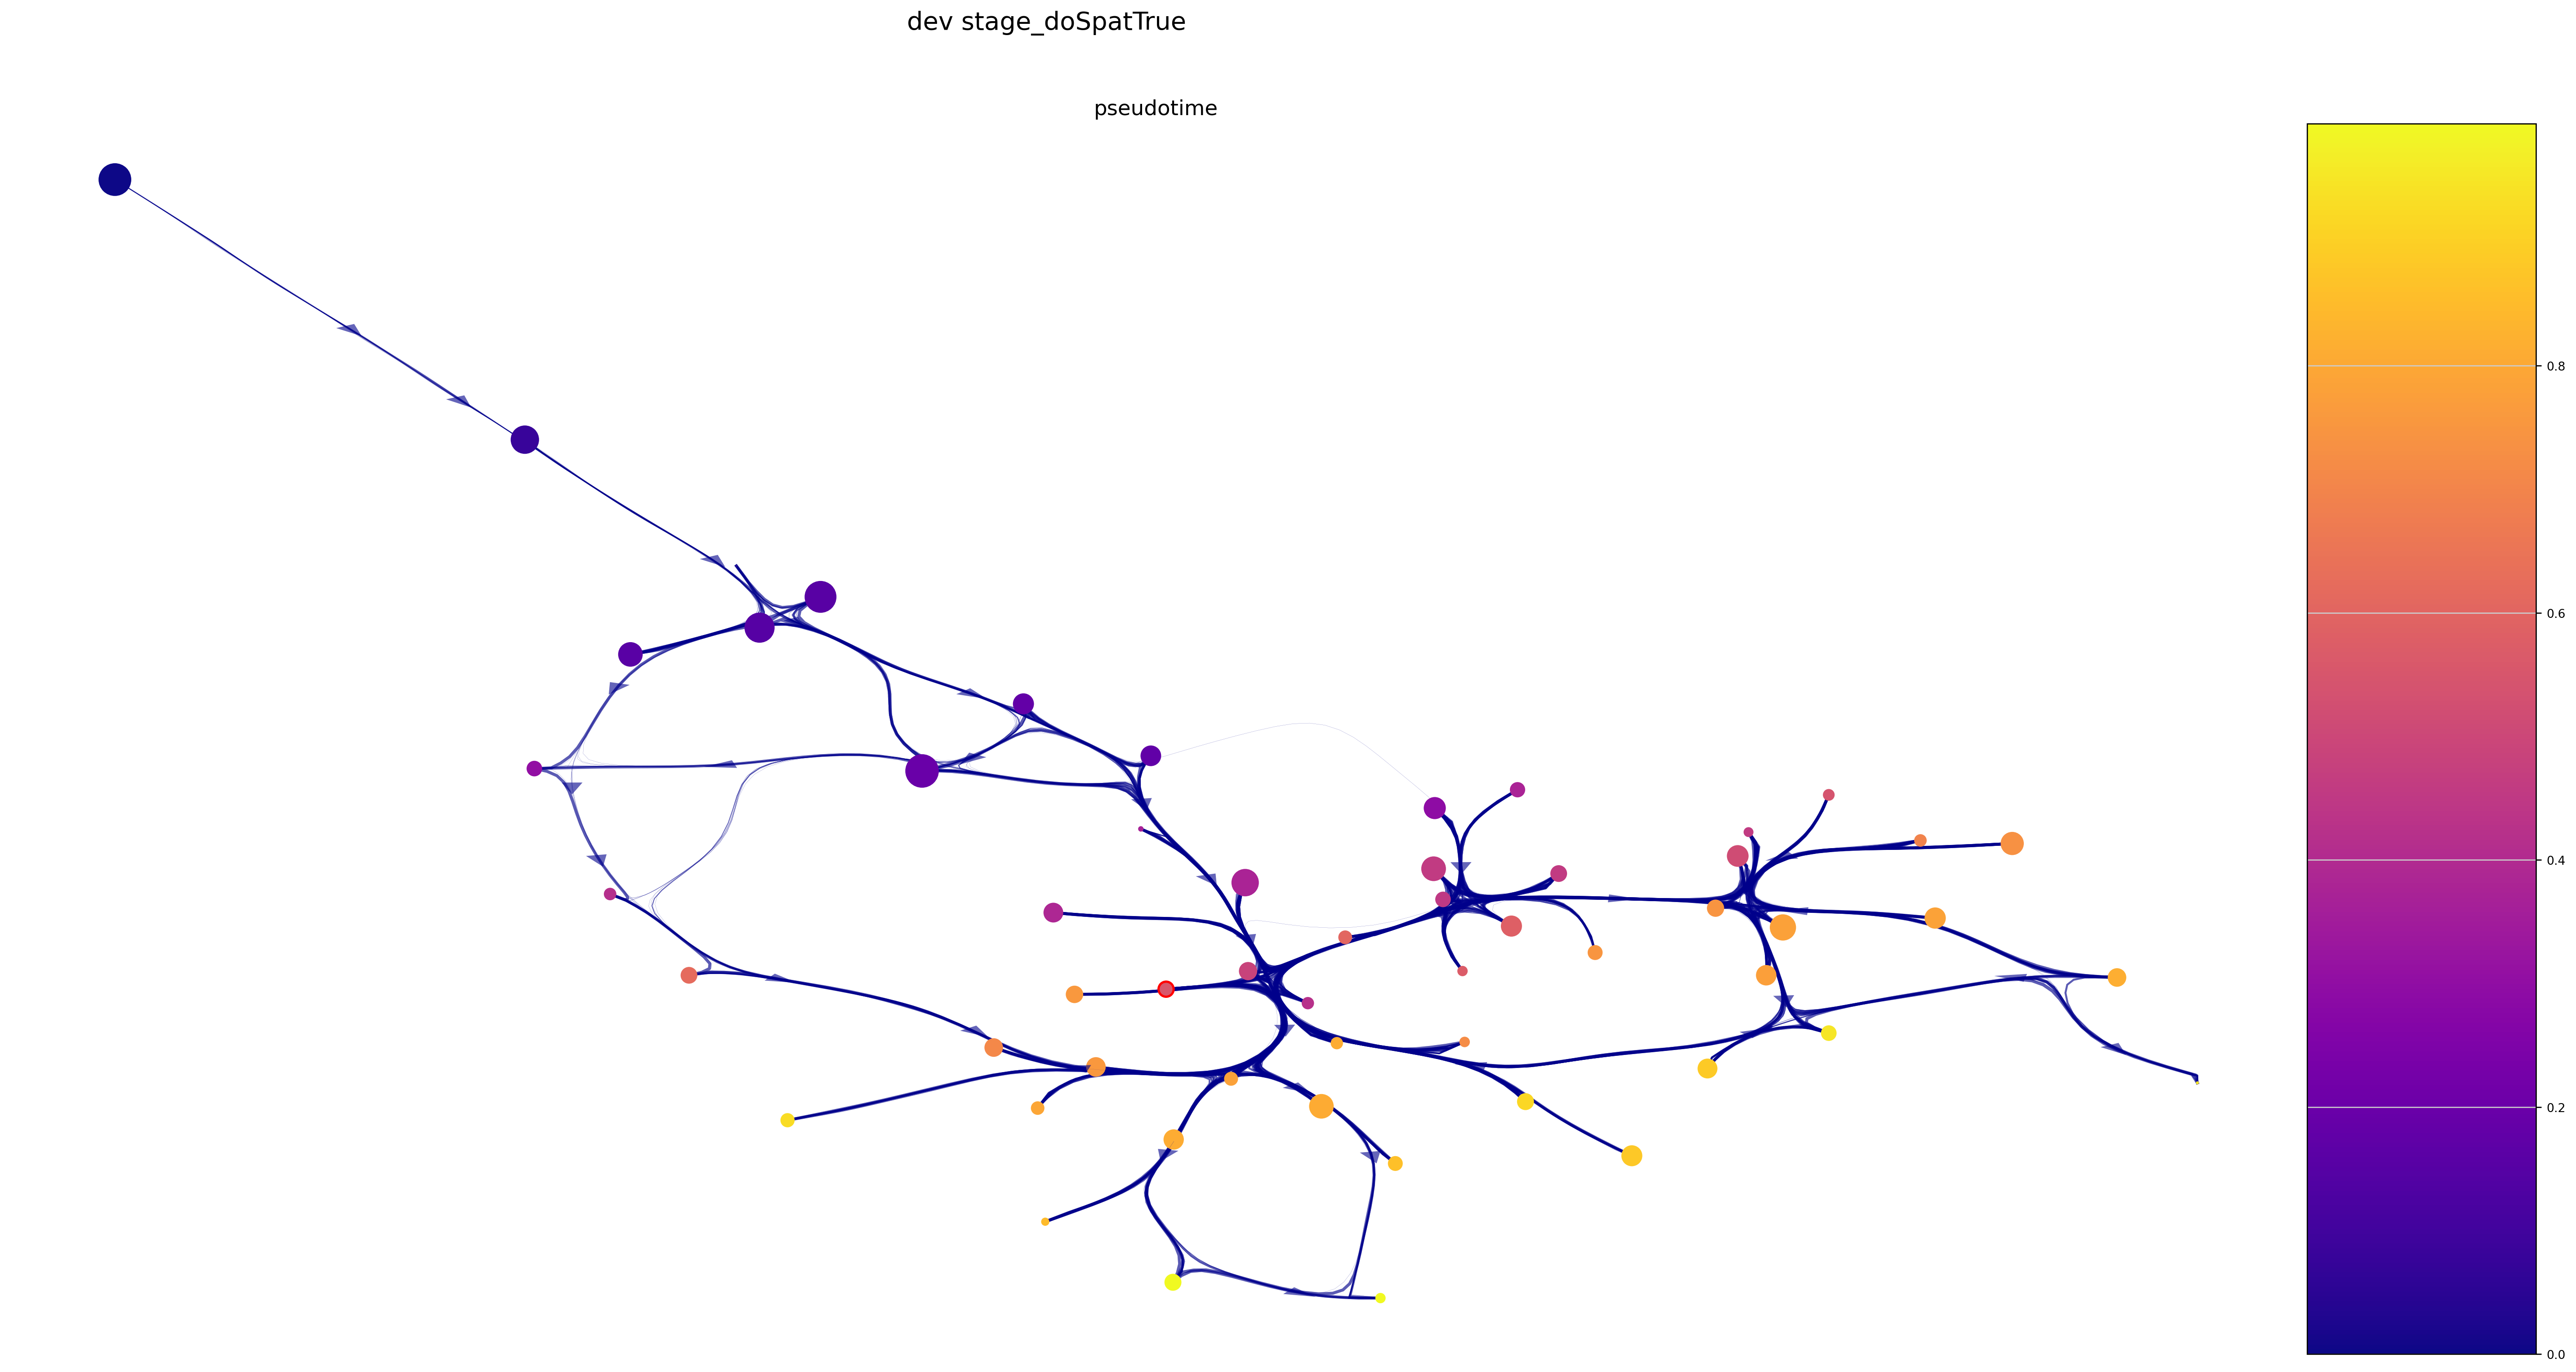

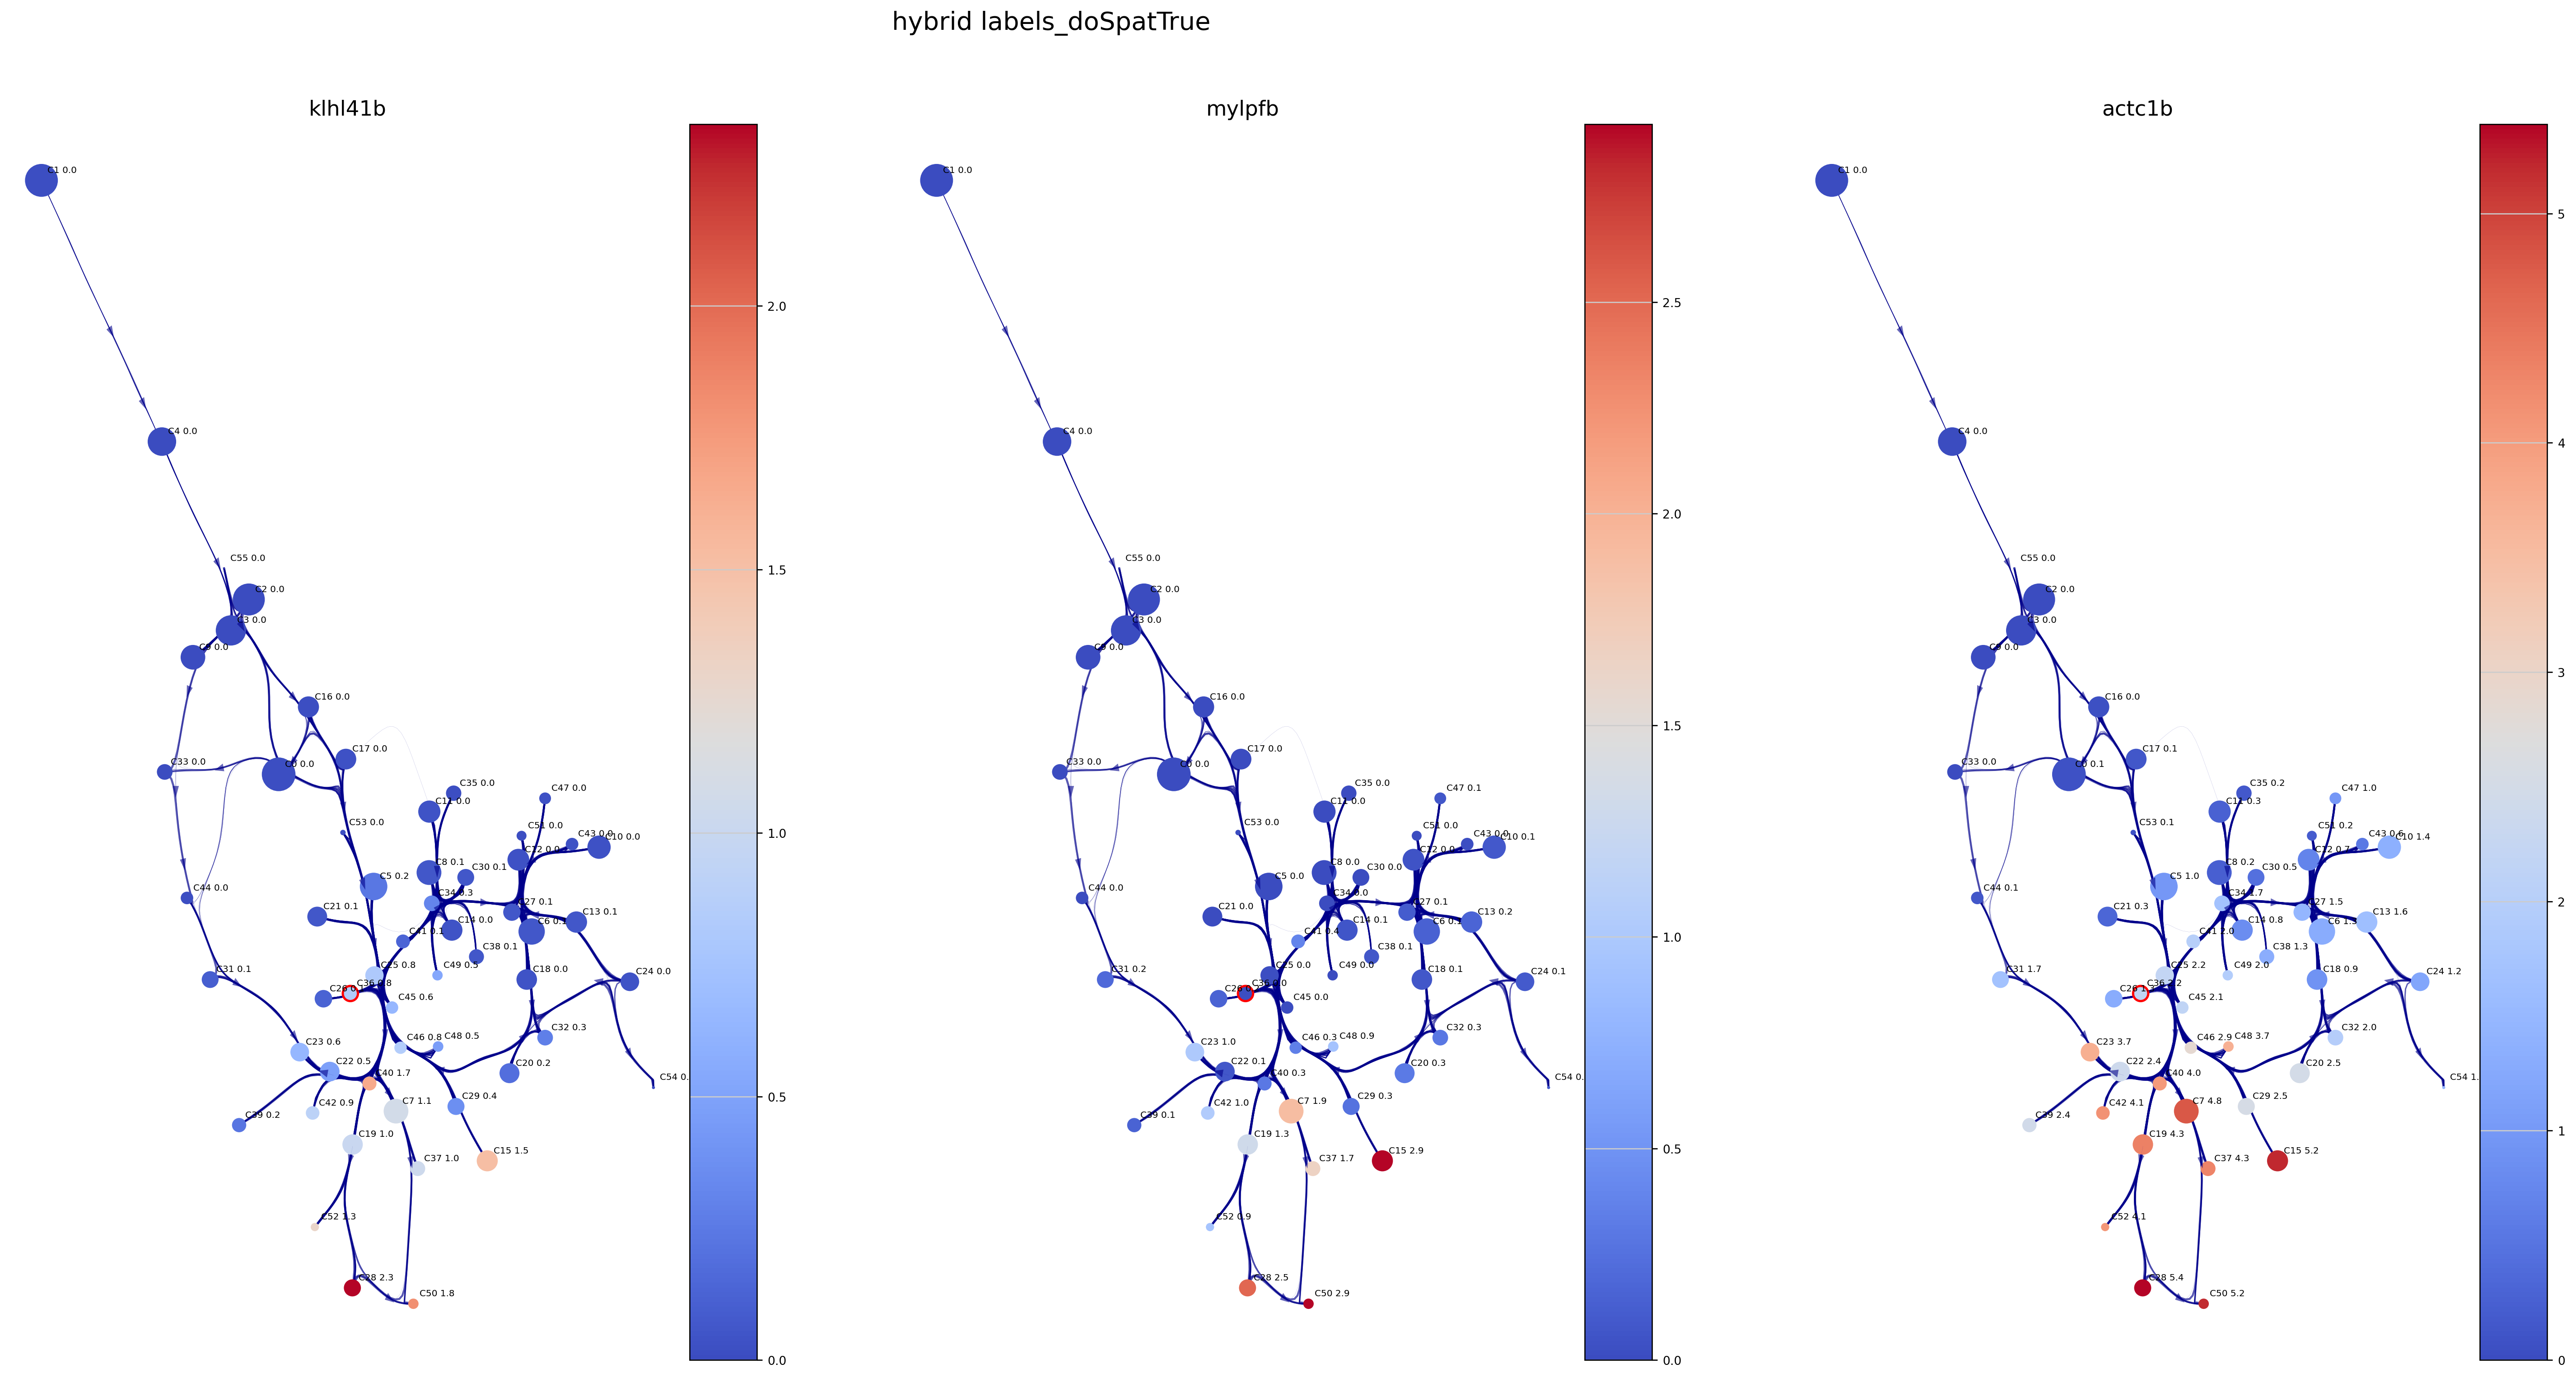

In [16]:
plot_viagraph_categorical = True

if plot_viagraph_categorical:
    #plotting viagraph colored by categorical labels (e.g. stages, cell types)
    f1, ax1 =via.plot_piechart_only_viagraph(via_object=v0, cmap_piechart='plasma',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=False,
                                                  reference_labels=time_numeric, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False)
    f1.set_size_inches(3,3)
    f2, ax2 = via.plot_piechart_only_viagraph(via_object=v0, cmap_piechart='rainbow',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=True,
                                                  reference_labels=true_labels_hybrid, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False, fontsize=4)
    f2.set_size_inches(3, 3)

plot_viagraph_continuous = True

if plot_viagraph_continuous:
    # plotting the viagraph colored by pseudotime, default edges
    # via.plot_viagraph(via_object=v0, tune_edges=False)
    # plotting the viagraph colored by pseudotime, tuning visualized edges
    # via.plot_viagraph(via_object=v0, tune_edges=True, cmap='viridis', initial_bandwidth=0.05, decay=0.7, edgebundle_pruning=0.5)

    f1, ax1 = via.plot_viagraph(via_object=v0, cmap='plasma',
                                              edgeweight_scale=1.5, label_text=False)
                                              
                                             
    f1.set_size_inches(30, 15)
    f1.suptitle('dev stage' + '_doSpat' + str(do_spatial))
    genes = ['klhl41b', 'mylpfb', 'actc1b'] #muscle related genes.
    df_genes_sc = pd.DataFrame(adata[:, genes].X.todense(), columns=genes)
    f2, ax1 = via.plot_viagraph(via_object=v0, df_genes=df_genes_sc, gene_list=genes,
                                              edgeweight_scale=1, label_text=True    )
    f2.set_size_inches(30, 15)
    f2.suptitle('hybrid labels' + '_doSpat' + str(do_spatial))

#### Let's say you are very happy with the clusters you have computed based on previous run using StaVia, or you would like to use a subset of the terminal states it has identified, or even modify the list of terminal states and provide some more user defined guidance. In StaVia you can pass these on as input parameters to fix the clusters and terminal states in the following manner
- the user definted terminal states can be provided as group level fates that correspond to the labels found in the "true_label" parameter OR can be given as a list of single-cell indices as user_defined_terminal_cells = ['list of numeric indices of cells'].
- in the example below we use clusters that were identified in prior runs of StaVia as terminal cell fatesm as the user_defined_terminal_group. We therefore need to ensure that these labels exist in the true_label parameter

In [18]:
pre_labels = [int(i) for i in adata.obs['via_clusters']]
v0 = via.VIA(data=input, true_label=pre_labels,
             edgepruning_clustering_resolution=edgepruning_clustering_resolution, labels=pre_labels,
             edgepruning_clustering_resolution_local=1, knn=knn, knn_sequential=knn_sequential,
             knn_sequential_reverse=knn_sequential,
             cluster_graph_pruning=cluster_graph_pruning,resolution_parameter=resolution_parameter,
             root_user=root, random_seed=random_seed,user_defined_terminal_group=[26,46,10, 13, 17, 21, 24, 28, 30, 34, 36, 37, 39, 41, 43, 53, 61, 64, 65, 71,20,57,66,29,22] ,
             t_diff_step=t_diff_step,edgebundle_pruning=cluster_graph_pruning, edgebundle_pruning_twice=False,
             time_series_labels=time_numeric, time_series=time_series,
             spatial_aux=spatial_aux,
             do_spatial_knn=do_spatial, do_spatial_layout=False, spatial_coords=coords, spatial_knn=spatial_knn)

v0.run_VIA()


2024-05-08 10:05:00.530513	Running VIA over input data of 152977 (samples) x 30 (features)
2024-05-08 10:05:00.530596	Knngraph has 20 neighbors
2024-05-08 10:05:32.807649	Using time series information to guide knn graph construction 
2024-05-08 10:05:32.810528	Time series ordered set [3, 5, 10, 12, 18, 24]
2024-05-08 10:06:26.467705	Shape neighbors (152977, 20) and sequential neighbors (152977, 10)
2024-05-08 10:06:26.503122	Shape augmented neighbors (152977, 30)
2024-05-08 10:06:26.527353	Actual average allowable time difference between nodes is 8.4
2024-05-08 10:06:35.594145	Using spatial information to guide knn graph construction + combining with time-series data
2024-05-08 10:06:35.597896	These slices are present: ['10_1', '10_10', '10_11', '10_12', '10_13', '10_14', '10_15', '10_16', '10_17', '10_18', '10_19', '10_2', '10_20', '10_21', '10_22', '10_23', '10_24', '10_25', '10_26', '10_3', '10_4', '10_5', '10_6', '10_7', '10_8', '10_9', '12_1', '12_10', '12_11', '12_12', '12_2', '1

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2024-05-08 10:08:00.280761	Terminal cluster list based on user defined cells/groups: [(26, 26), (46, 46), (10, 10), (13, 13), (17, 17), (21, 21), (24, 24), (28, 28), (30, 30), (34, 34), (36, 36), (37, 37), (39, 39), (41, 41), (43, 43), (53, 53), (61, 61), (64, 64), (65, 65), (71, 71), (20, 20), (57, 57), (66, 66), (29, 29), (22, 22)]
2024-05-08 10:08:00.281035	Terminal clusters corresponding to unique lineages in this component are [26, 46, 10, 13, 17, 21, 24, 28, 30, 34, 36, 37, 39, 41, 43, 53, 61, 64, 65, 71, 20, 57, 66, 29, 22] 
2024-05-08 10:08:00.281060	Calculating lineage probability at memory 5


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pecanpy/graph.py:90: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-05-08 10:08:06.638440	Cluster or terminal cell fate 26 is reached 576.0 times
2024-05-08 10:08:06.719356	Cluster or terminal cell fate 46 is reached 924.0 times
2024-05-08 10:08:06.862167	Cluster or terminal cell fate 10 is reached 99.0 times
2024-05-08 10:08:07.005036	Cluster or terminal cell fate 13 is reached 670.0 times
2024-05-08 10:08:07.239039	Cluster or terminal cell fate 17 is reached 239.0 times
2024-05-08 10:08:07.344238	Cluster or terminal cell fate 21 is reached 442.0 times
2024-05-08 10:08:07.438323	Cluster or terminal cell fate 24 is reached 883.0 times
2024-05-08 10:08:07.560577	Cluster or terminal cell fate 28 is reached 918.0 times
2024-05-08 10:08:07.721966	Cluster or terminal cell fate 30 is reached 770.0 times
2024-05-08 10:08:07.833380	Cluster or terminal cell fate 34 is reached 966.0 times
2024-05-08 10:08:07.924998	Cluster or terminal cell fate 36 is reached 898.0 times
2024-05-08 10:08:08.098273	Cluster or terminal cell fate 37 is reached 626.0 times
2024-

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


2024-05-08 10:08:20.343423	Time elapsed 172.2 seconds


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/pyVIA/plotting_via.py:3513: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],


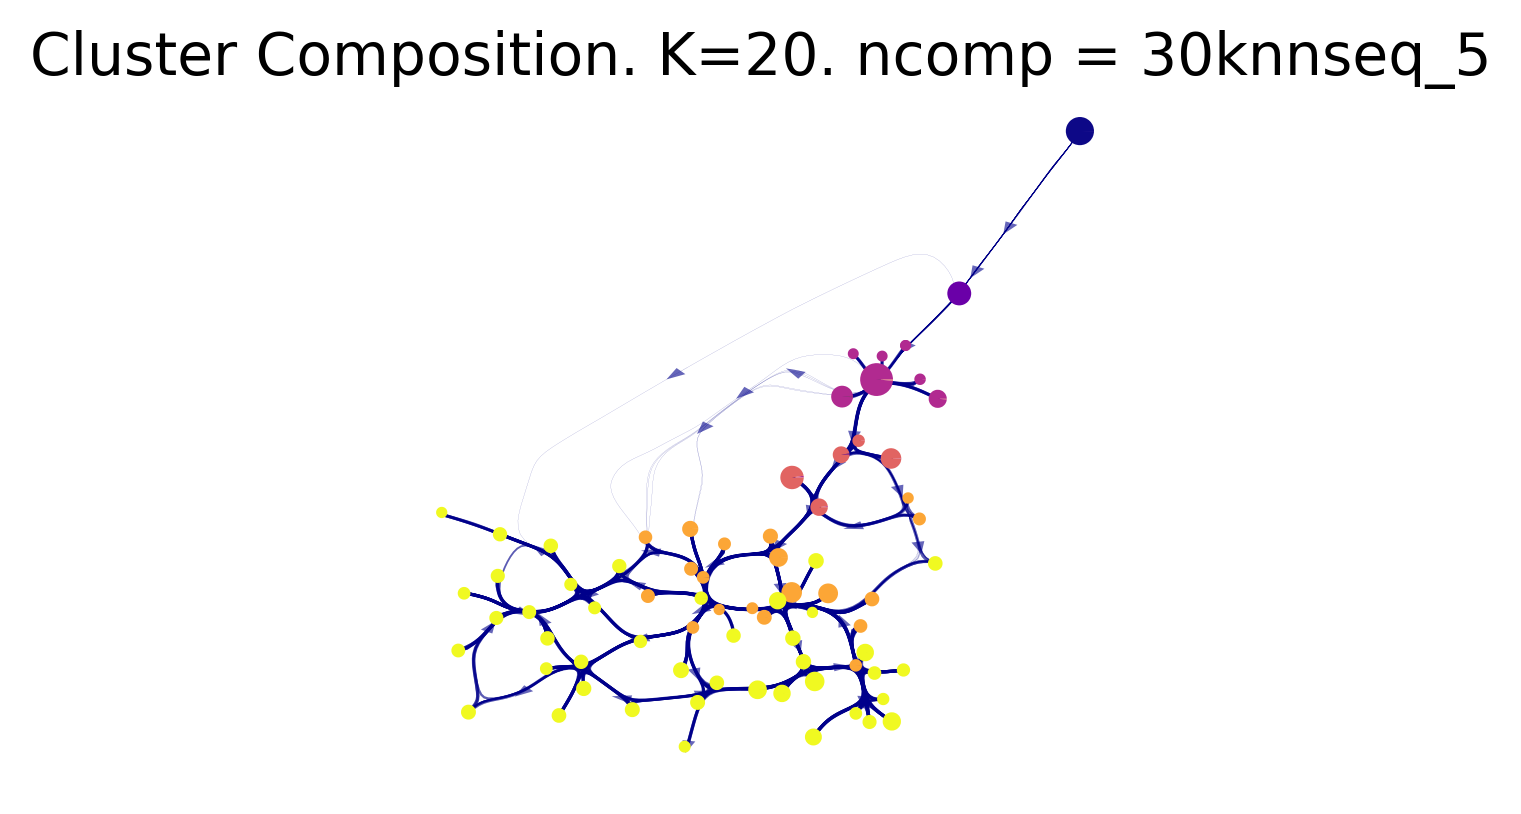

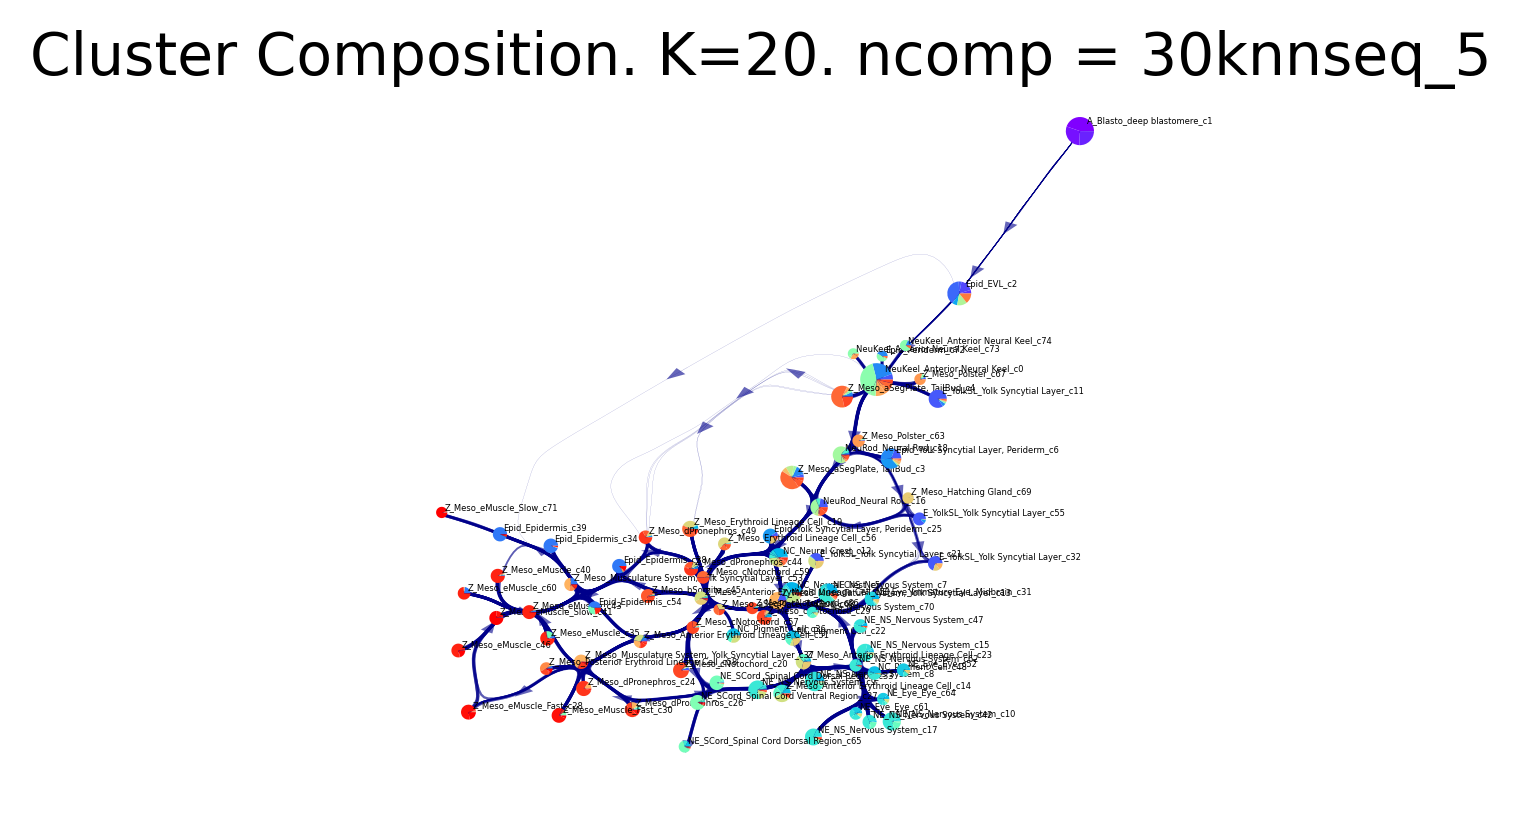

In [20]:
plot_viagraph_categorical = True

if plot_viagraph_categorical:
    #plotting viagraph colored by categorical labels (e.g. stages, cell types)
    f1, ax1 =via.plot_piechart_only_viagraph(via_object=v0, cmap_piechart='plasma',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=False,
                                                  reference_labels=time_numeric, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False)
    f1.set_size_inches(3,3)
    f2, ax2 = via.plot_piechart_only_viagraph(via_object=v0, cmap_piechart='rainbow',
                                                  pie_size_scale=0.4, linewidth_edge=0.6, ax_text=True,
                                                  reference_labels=true_labels_hybrid, headwidth_arrow=0.2,
                                                  highlight_terminal_clusters=True, show_legend=False, fontsize=2)
f2.set_size_inches(3, 3)

In [ ]:
v0.terminal
print('plot lineage prob')
for ts_i in [26, 30, 28, 46]:  # [20,57,13,21,41,43,30,66,29,36,22,10,17,61,64]:
    via.plot_sc_lineage_probability(via_object=v0, embedding=coords, marker_lineages=[ts_i],
                                    scatter_size=1)
